# Modelagem e criação de modelos de classificação com machine learning para algorítmos de tradding 

### 1 Aquisição dos dados da API

A aquisição dos dados é feita através do wrapper para a REST API da Binance. Os dados são basicamente o preço do ativo no formato OHLCV (Open, High, Low, Close e Volume), em seguida se faz o parse para um dataframe do Pandas

In [1]:
import requests, json
from binance.client import Client
from binance.enums import *

import pandas as pd
import numpy as np
import time
from datetime import datetime

from math import pi
from bokeh.plotting import figure, show, output_file
from bokeh.sampledata.stocks import MSFT
from bokeh.models import Band
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


class Aquisition(object):
    
    
    def __init__(self):
        self.client = Client('', '')
        self.df = pd.DataFrame(columns= ['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time'])
           
    def cast_to_dataframe(self, opentime, lopen, lhigh, llow, lclose, lvol, closetime):
        self.df['Open_time'] = opentime
        self.df["date"] = opentime
        self.df['Open'] = np.array(lopen).astype(np.float)
        self.df['High'] = np.array(lhigh).astype(np.float)
        self.df['Low'] = np.array(llow).astype(np.float)
        self.df['Close'] = np.array(lclose).astype(np.float)
        self.df['Volume'] = np.array(lvol).astype(np.float)
        self.df['Close_time'] = closetime
        self.df["date"] = pd.to_datetime(self.df['date'],unit='ms')
        
    def parse(self, candles):   
        opentime, lopen, lhigh, llow, lclose, lvol, closetime = [], [], [], [], [], [], []
        for candle in candles:
            opentime.append(candle[0])
            lopen.append(candle[1])
            lhigh.append(candle[2])
            llow.append(candle[3])
            lclose.append(candle[4])
            lvol.append(candle[5])
            closetime.append(candle[6])    
        self.cast_to_dataframe(opentime, lopen, lhigh, llow, lclose, lvol, closetime)
        
    def get_candles(self):
        candles = self.client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1DAY)
        self.parse(candles)
        return self.df
    
    def get_price_now(self):
        r = requests.get("https://www.binance.com/api/v3/ticker/price?symbol=BTCUSDT")
        r = r.content
        jsonResponse = json.loads(r.decode('utf-8'))
        return float(jsonResponse['price'])
    
    
    def plot_candles(self):
        df = self.df[450:]
        df["date"] = df["Open_time"]
        df["date"] = pd.to_datetime(self.df['date'],unit='ms')
        inc = df.Close > df.Open
        dec = df.Open > df.Close
        w = 12*60*60*1000 # half day in ms
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "BITCOIN Candlestick")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3
        p.segment(df.date, df.High, df.date, df.Low, color="black")
        p.vbar(df.date[inc], w, df.Open[inc], df.Close[inc], fill_color="#006400", line_color="black")
        p.vbar(df.date[dec], w, df.Open[dec], df.Close[dec], fill_color="#F2583E", line_color="black")
        output_file("candlestick.html", title="candlestick.py Grafico de Candles")
        show(p)  

O datafreme resultante pode ser visto abaixo:

In [2]:
candles = Aquisition()
dataframe = candles.get_candles()
dataframe.head()

,Open_time,Open,High,Low,Close,Volume,Close_time,date
0,1504742400000,4619.77,4788.59,4438.19,4691.61,500.429975,1504828799999,2017-09-07
1,1504828800000,4691.66,4735.39,4028.93,4282.80,1132.255046,1504915199999,2017-09-08
2,1504915200000,4282.80,4426.62,4150.06,4258.81,658.782952,1505001599999,2017-09-09
3,1505001600000,4258.81,4283.00,3801.00,4130.37,660.373275,1505087999999,2017-09-10
4,1505088000000,4153.62,4334.43,4098.91,4208.47,699.989065,1505174399999,2017-09-11


Então plota-se com o bokeh os candles com um stock chart no formato OHLCV

In [3]:
candles.plot_candles()

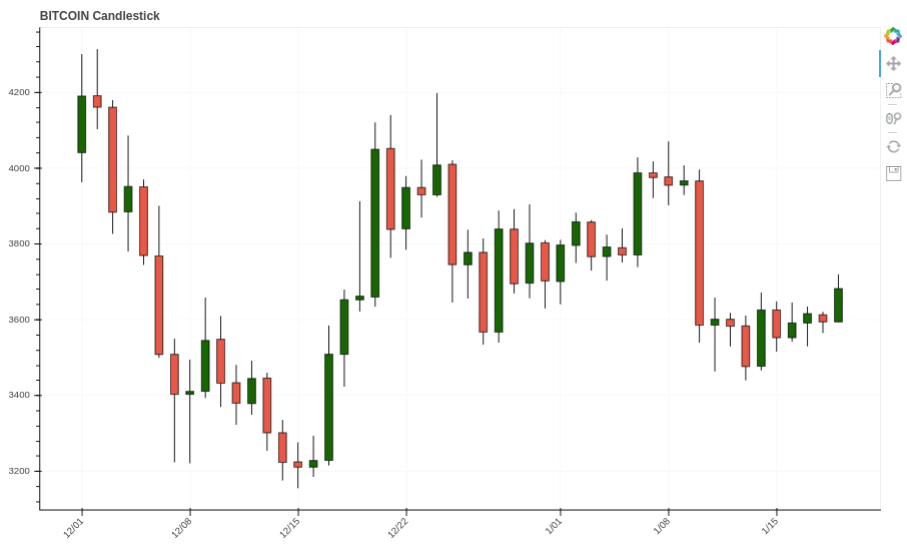


### Iterpretando um candle:

#### Os 3 elementos dos Candlesticks

#### 1. Período

O principal conceito dos candlesticks é que cada candle representa o que ocorreu com o preço de uma ação durante um determinado período de tempo. Cada candle pode representar 1 minuto, 5 minutos, 1 hora, 1 semana, 1 mês e até mesmo 1 ano. Você é que escolhe.

#### 2. Formato
O formato do candle por sua vez é determinado por importantes valores que o preço da ação atingiu durante este determinado período. São os preço de:

+abertura
+fechamento
+mínimo
+máximo

Estes valores dão forma aos dois elementos que compões um Candle:

o corpo (que traz as informações de fechamento e abertura), e
a sombra (que informa os máximos e mínimos do período)

#### 3. Cor
O terceiro elemento que compões um candlestick é a sua cor, e isso determina se o candlestick é de alta ou de baixa.

Quando o preço de fechamento está abaixo do preço de abertura, significa que o preço da ação caiu durante aquele determinado período, e o Candle será de baixa.

Quando o preço de fechamento for maior que o preço de abertura, significa que o preço subiu durante aquele período e o candlestick será de alta.

Veja na figura abaixo como interpretar cada um dos três elementos do candlestick:

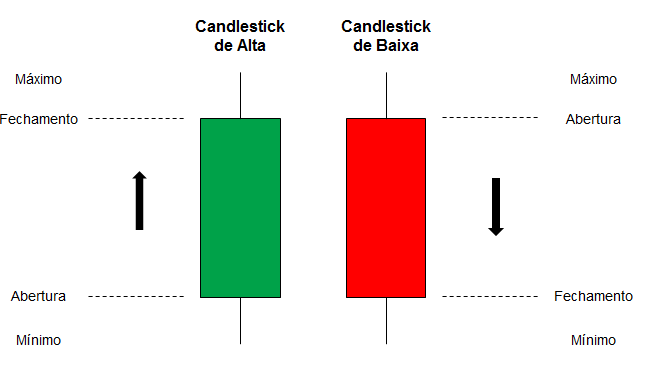

## Calculando indicadores

Infelizmente apesar dos candles de nos dizerem muito sobre o ativo ainda não são dados suficiente para rodar nos algorítmos, para isso calculam-se alguns indicadores de mercado. Indicadores de mercado são métodos práticos para obter estimativas sobre o valor da empresa, então são amplamente utilizados por traders para a comparação entre ações facilitando (ou não na tomada de decisão)

Existem muitos indicadores famosos e a maioria é explicita por formulas matemáticas com base em estatística, um exemplo são as famosas Bandas de boillinger

Análise de Bollinger (também conhecida como Bandas de Bollinger) são ferramentas de análise técnica criadas por John Bollinger no início dos anos 80. Este indicador possui uma forte relação com a volatilidade, possibilitando, assim, a sua comparação com os níveis de preços num determinado período de tempo. O maior objetivo das bandas Bollinger é fornecer uma ideia relativa de alto e baixo. Por definição, os preços são altos na linha (banda) superior e baixos na linha (banda) inferior.

O indicador é calculado pela seguinte formula: 

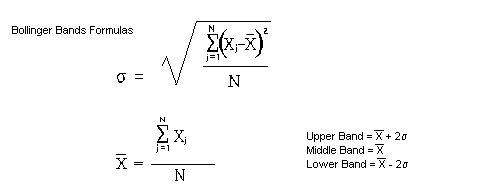

***Vamos a implementação:*** 

In [4]:
class Bbands(Aquisition):  
    
    
    def __init__(self, nDer = 2, period = 20):
        super(Bbands, self).__init__()
        self.candles = super().get_candles()
        self.nDer = nDer
        self.period = period
    
    def eval_boillinger_bands(self):
        self.candles['30 Day MA'] = self.candles['Close'].rolling(window=self.period).mean()
        self.candles['30 Day STD'] = self.candles['Close'].rolling(window=self.period).std()
        self.candles['Upper Band'] = self.candles['30 Day MA'] + (self.candles['30 Day STD'] * self.nDer)
        self.candles['Lower Band'] = self.candles['30 Day MA'] - (self.candles['30 Day STD'] * self.nDer)
        
    def configure_plot(self, df):
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "Bbands Chart")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3
        p.line(df.date, df.Close, line_color="black")
        p.line(df.date, df['30 Day MA'], line_color="red", legend="30 Day MA", muted_alpha=0.2)
        p.line(df.date, df['Upper Band'], line_color="blue", legend="Upper Band", muted_alpha=0.2)
        p.line(df.date, df['Lower Band'], line_color="green", legend="Lower Band", muted_alpha=0.2)
        
        p.legend.location = "top_left"
        p.legend.click_policy="mute"
        return p
        
    def plot_bands(self):
        df = self.candles
        p = self.configure_plot(df)
        output_file("candlestick.html", title="candlestick.py Bbands")
        show(p)  
        
    def plot_cross_points(self):
        self.eval_boillinger_bands()
        
        self.candles['up_cross'] = np.where((self.candles['Close'] >= self.candles['Upper Band'])
                                            , self.candles['Close'], None)       
        self.candles['down_cross'] = np.where((self.candles['Close'] <= self.candles['Lower Band'])
                                              , self.candles['Close'], None)
        
        p = self.configure_plot(self.candles)        
        p.circle(self.candles.date, self.candles['up_cross'], size=5, color="red", alpha=1, legend="Up cross")
        p.circle(self.candles.date, self.candles['down_cross'], size=5, color="green", alpha=1,legend="Down cross")   
        output_file("candlestick.html", title="candlestick.py Bbands")
        show(p)  
        
    def detect_cross(self):
        self.eval_boillinger_bands()   
        self.candles['up_cross'] = np.where((self.candles['Close'] >= self.candles['Upper Band']) , 1, 0)
        self.candles['down_cross'] = np.where((self.candles['Close'] <= self.candles['Lower Band']) , 1,  0)

### Visualização das bandas:

Pode-se visualizar as bandas calculadas para uma melhor interpretação

In [5]:
bands = Bbands()
bands.eval_boillinger_bands()
bands.plot_bands()

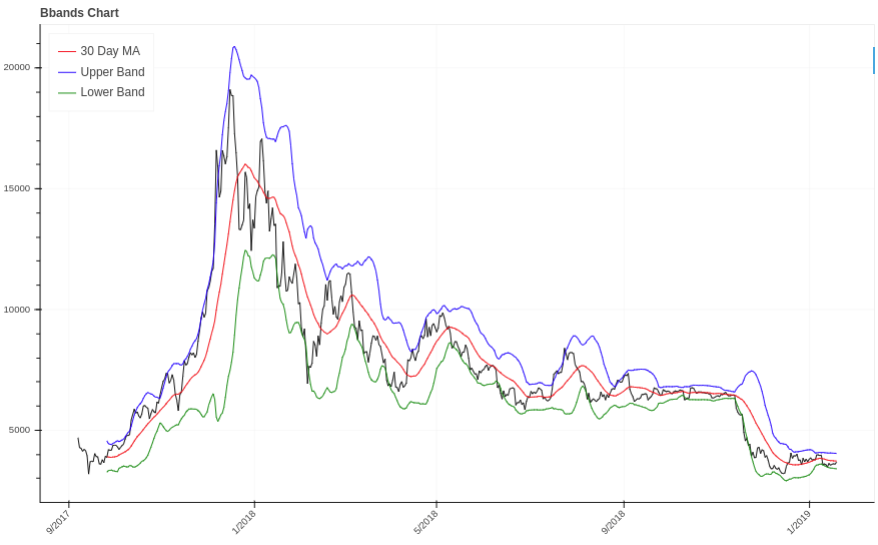

#  Cross

Outro ponto importante é a possibilidade de adicionar uma interpretação as bandas extraindo mais um sinal delas, são os pontos de cruzamento da linha do fechamento (close) com as bandas superiores e inferiores. 

In [6]:
bands.plot_cross_points()

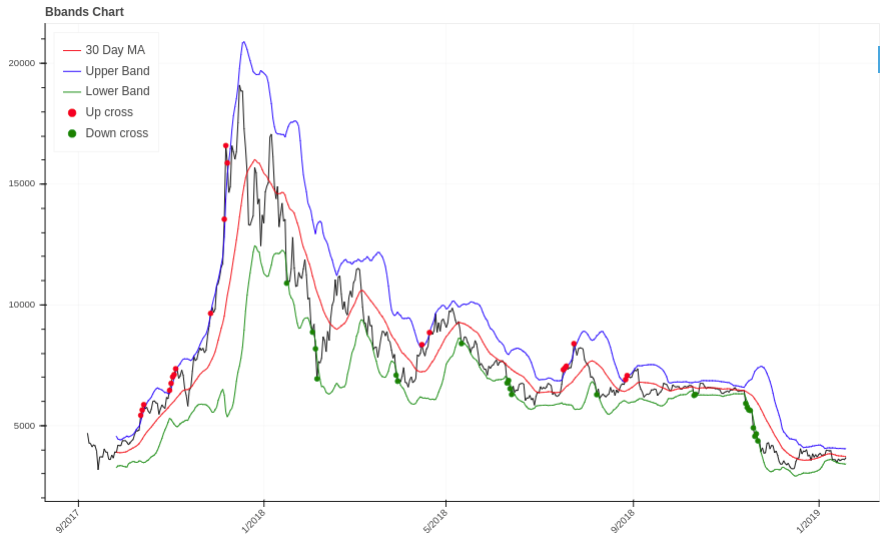

Adicionando todos esse indicadores nosso dataframe fica o seguinte:

In [7]:
bands.detect_cross()
bands.df.head()

,Open_time,Open,High,Low,Close,Volume,Close_time,date,30 Day MA,30 Day STD,Upper Band,Lower Band,up_cross,down_cross
0,1504742400000,4619.77,4788.59,4438.19,4691.61,500.429975,1504828799999,2017-09-07,NaN,NaN,NaN,NaN,0,0
1,1504828800000,4691.66,4735.39,4028.93,4282.80,1132.255046,1504915199999,2017-09-08,NaN,NaN,NaN,NaN,0,0
2,1504915200000,4282.80,4426.62,4150.06,4258.81,658.782952,1505001599999,2017-09-09,NaN,NaN,NaN,NaN,0,0
3,1505001600000,4258.81,4283.00,3801.00,4130.37,660.373275,1505087999999,2017-09-10,NaN,NaN,NaN,NaN,0,0
4,1505088000000,4153.62,4334.43,4098.91,4208.47,699.989065,1505174399999,2017-09-11,NaN,NaN,NaN,NaN,0,0


Agora além dos indicadores do gráfico OHLCV ainda temos uma media móvel, o desfio padrão o valor das bandas de boillinger e o cruzamento das mesmas. Observe que poluimos o dataframe com campos de data missing (NaN), esses pontos se encontram nos candles iniciais antes de existirem pontos suficientes para calcular as medias móveis

## Adicionando mais indicadores

Agora que sabemos o que são indicadores e como implementa-los vamos ao modo mais fácil e adicionar mais alguns usando a biblioteca pyti



In [14]:
from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.aroon import aroon_down, aroon_up
from pyti.ichimoku_cloud import tenkansen, kijunsen, chiku_span, senkou_a, senkou_b
from pyti.momentum import momentum

class Indicators():
    def __init__(self, candles):
        self.candles = candles
    
    def add_indicators(self):
        self.candles = self.candles.drop(['Open_time', 'Close_time'], axis=1)
        self.candles['EMA - 15'] = ema(self.candles['Close'].tolist(), 15)
        self.candles['aaron down'] = aroon_down(self.candles['Close'].tolist(), 25)
        self.candles['aaron up'] = aroon_up(self.candles['Close'].tolist(), 25)
        self.candles['tenkansen'] = tenkansen(self.candles['Close'].tolist())
        self.candles['kijunsen'] = kijunsen(self.candles['Close'].tolist())
        self.candles['momentun'] = momentum(self.candles['Close'], 15)
        return self.candles

Os indicadores escolhidos (arbitrariamente) foram:

+ Media móvel esponencial de 15 valores
+ arron up e down
+ Nuvens de ichimoku (tenkasen, kijusen)
+ momentun

#### O dataframe resultante é o seguinte:

In [164]:
idc = Indicators(bands.df)
df = idc.add_indicators()
df.head()

,Open,High,Low,Close,Volume,date,30 Day MA,30 Day STD,Upper Band,Lower Band,up_cross,down_cross,EMA - 15,aaron down,aaron up,tenkansen,kijunsen,momentun
0,4619.77,4788.59,4438.19,4691.61,500.429975,2017-09-07,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,4691.66,4735.39,4028.93,4282.80,1132.255046,2017-09-08,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,4282.80,4426.62,4150.06,4258.81,658.782952,2017-09-09,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,4258.81,4283.00,3801.00,4130.37,660.373275,2017-09-10,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,4153.62,4334.43,4098.91,4208.47,699.989065,2017-09-11,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# A análise de correlação

Para verificar a correlação entre os indicadores pode-se criar uma matriz com os coeficientes de pearson utilizando o seaborn.

Os coefieientes de pearson são úteis pois mostram a correlação entre duas séries temporais.

Remove-se as colunas High, Low e Open para se observar mais facilmente a correlação entre as variáveis Close e os demais indicadores

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
class Corr(object):
    def __init__(self, df):
        self.df = df
        try:
            self.df = self.df.drop(['High', 'Low', 'Open'], axis=1)
        except:
            pass
    
    def pearson(self):
        plt.figure(figsize=(12,8))
        kwargs = {'fontsize':12,'color':'black'}
        sns.heatmap(self.df.corr(),annot=True,robust=True)
        plt.title('Correlation Analysis',**kwargs)
        plt.tick_params(length=3,labelsize=12,color='black')
        plt.yticks(rotation=0)
        plt.show()

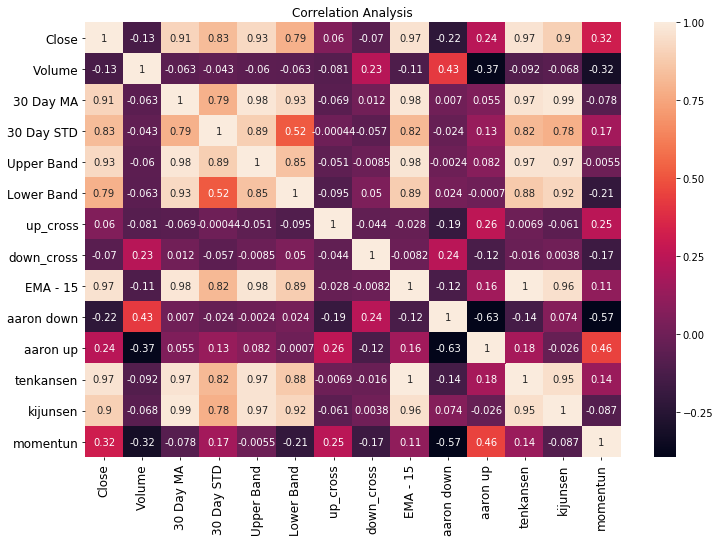

In [166]:
c = Corr(df)
c.pearson()


Como esperado pode-se observar uma alta correlação entre as médias móveis e ichimoku com Close, essa correlação pode servir de base pra criar uma feature selection.

# Criando variável target

Como os indicadores estão calculados o proximo passo é definir uma variável target para o algorítmo classificar.

O método utilizado é look ahead descrito abaixo:
```
    1 Para cada candle do dataframe
    2 Observe o close do candle atual e do candle atual + 10
    2 se close < close+10
    3    pinte o candle de verde
    4 senao pinte o candle de vermelho
```

Assim quando o preço subiu no futuro o candle atual ficara verde indicando um ponto de compra e ao contrário ficará vermelho indicando venda, essa técnica é relativamente boa pra detectar vales e picos

In [167]:
class Target(object):
    def __init__(self, candles):
        self.candles = candles
        self.buy = [] 
        self.sell = []
        self.hold = []
        self.close = self.candles['Close'].tolist() 
        
        
    def fill(self, vBuy, vSell):
        self.buy.append(vBuy) 
        self.sell.append(vSell)
        
    def test_target(self):
        for i in range (0, len(self.close)-11):
            if float(self.close[i]) < float(self.close[i+10]):
                self.fill(self.close[i], 'NaN')
            elif float(self.close[i]) > float(self.close[i+10]):
                self.fill('NaN', self.close[i])
                
        for i in range (len(self.candles.Close)-12, len(self.candles.Close)):
            self.fill('NaN', 'NaN')

        self.candles['buy'] = self.buy
        self.candles['sell'] = self.sell
        
    def plot_targets(self):   
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "Target Chart")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3

        p.line(self.candles.date, self.candles.Close, line_color="black")

        p.circle(self.candles.date, self.candles['sell'], size=5, color="red", alpha=1, legend='buy')
        p.circle(self.candles.date, self.candles['buy'], size=5, color="green", alpha=1, legend='sell')

        output_file("candlestick.html", title="candlestick.py Bbands")
        show(p)  

O resultado gráfico do look ahead pode ser observado abaixo:

In [168]:
tgt = Target(df)
tgt.test_target()
tgt.plot_targets()

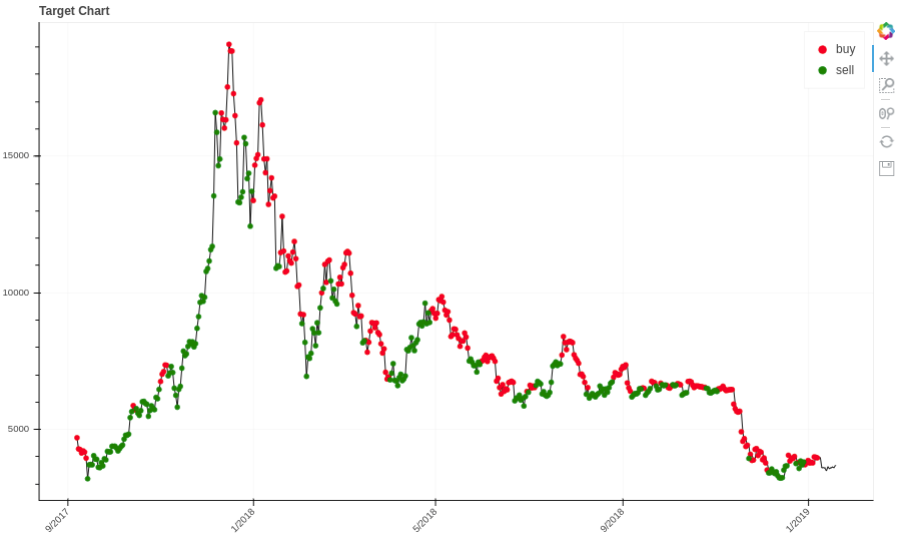

Adiciona-se o target ao dataframe:

+ 0- indica um ponto de compra (verde)
+ 1- indica um ponto de venda (vermelho)

In [170]:
def createTarget(candles):
    
    close = candles['Close'].tolist()
    target = []
    
    for i in range (0, len(close)-11):
        if float(close[i]) < float(close[i+10]):
            target.append(0)

        elif float(close[i]) > float(close[i+10]):
            target.append(1)
            
    for i in range (488, 500):
        target.append('NaN')
        
    candles['target'] = target

In [171]:
targ = tgt.candles
createTarget(targ)

Esse método é muito simples e pode ter sua eficiência facilmente medida percorrendo cada target e verificando a mudança de sinal. e classificando o trade como vencedor ou perdedor.

Se o preço na mudança de sinal de um trade de 0 para 1 o preço anterior for maior que o posterior o trade é vencedor, senão é perdedor (respeitando a lei da vida compre na baixa e venda na alta)

In [172]:
class TestTarget():
    
    def __init__(self, candles):
        self.last_index = 0
        self.winner = 0 
        self.loser = 0
        self.last_buy = 0
        self.candles = candles
        self.win_percent = 0
        self.lose_percent = 0
        self.total_trades = 0
        
    def test(self):
        for candle in range (0, len(self.candles)):
            if(self.candles['target'][candle] == self.candles['target'][self.last_index]):
                pass
                  
            elif (self.candles['target'][candle] == 0 and self.candles['target'][self.last_index] == 1):
                self.last_index = candle
                self.last_buy = self.candles['Close'][candle]
            else:
                if (self.last_buy == 0):
                    pass
                elif (self.last_buy < self.candles['Close'][candle]):
                    self.winner += 1
                else:
                    self.loser += 1
                self.last_index = candle
    
    def eval_metrics(self):
        self.total_trades = self.winner + self.loser
        self.win_percent = self.winner / self.total_trades
        self.loss_percent = 1 - self.win_percent
        

In [173]:
test = TestTarget(tgt.candles)
test.test()

#### Metricas do teste

Obs: Essas métricas de forma alguma avaliam com perfeição a estratégia, existem outros calculos mais complexos usados que não seram abordados aqui como drawndown, fator de risco e etc...

In [174]:
test.eval_metrics()
print('Numero de acertos: {} \nNumero de erros: {} \nPorcentagem de acerto: {} \nPorcentagem de erro: {}'
      .format(test.winner, test.loser, test.win_percent, test.loss_percent) )

Numero de acertos: 21 
Numero de erros: 9 
Porcentagem de acerto: 0.7 
Porcentagem de erro: 0.30000000000000004


## NOTA IMPORTANTE

Essa taxa de acerto de  70%,  significa que nosso bot vai alcançar essa taxa de acerto mesmo que consigamos criar modelos de machine learning com 100% de precisão, pois os modelos são criados para prever os sinais de compra e venda. 
A solução para esse problema seria usar uma técnica de otimização que encontre os picos e vales do gráfico para que assim aumente a qualidade do nosso dataset conseguentemente diminuindo esse gargalo e melhorando o resultado final dos algorítmos. 
Ou seja no final para estimar o desempenho é necessário considerar esse erro e propaga-lo.

# Preparação dos dados para os algorítmos

### Limpeza dos dados

Para treinar os algorítmos são necessárias ações em relação a limpeza dos dados, para isso remove-se as colunas buy e sell que não são mais necessárias e remove-se também todas as colunas NaN (data missing).
Também realiza-se um backup do dataset como csv

In [178]:
class cleanData(object):
    def __init__(self, candles):
        self.candles = candles

    def clean(self):
        try:
            self.candles = self.candles.drop(['sell', 'buy'], axis=1)
        except:
            print('Erro apagando sell e buy')
            pass
        
        self.candles = self.candles.dropna()
        for column in self.candles:
            self.candles = self.candles[~self.candles[column].isin(['NaN'])]

        self.candles.to_csv('csv_ok', sep=',', encoding='utf-8')
        return self.candles

Abaixo o  dataframe limpo:

In [179]:
dt = cleanData(targ)
candles_no_NaN = dt.clean()
candles_no_NaN.head()

,Open,High,Low,Close,Volume,date,30 Day MA,30 Day STD,Upper Band,Lower Band,up_cross,down_cross,EMA - 15,aaron down,aaron up,tenkansen,kijunsen,momentun,target
25,4400.00,4561.63,4360.0,4380.00,655.756974,2017-10-02,3911.0930,308.809836,4528.712673,3293.473327,0,0,4119.311353,28.0,100.0,4020.010,3940.315,344.99,0
26,4380.00,4467.33,4180.8,4310.00,1082.323563,2017-10-03,3929.3585,321.446750,4572.252001,3286.464999,0,0,4148.509083,24.0,96.0,4131.175,3784.510,399.96,0
27,4314.90,4373.00,4142.0,4208.59,868.465101,2017-10-04,3980.3370,275.406421,4531.149842,3429.524158,0,0,4161.840210,20.0,92.0,4131.175,3784.510,308.59,0
28,4208.59,4355.00,4110.0,4292.43,779.138638,2017-10-05,4009.9585,275.527225,4561.012950,3458.904050,0,0,4185.815382,16.0,88.0,4277.250,3784.510,682.44,0
29,4318.99,4417.00,4292.0,4369.00,506.529176,2017-10-06,4042.6610,277.477500,4597.616000,3487.706000,0,0,4223.512344,12.0,84.0,4277.250,3784.510,773.13,0


# Definindo target, features e dividindo treino e  teste

Para a execução e validação dos algorítmos divide-se o dataset em treino e teste, onde 80% no caso é usado para treino e os outros 20% para testes.

Nesse passo também deve-se realizar a feature selection, que serão os inputs do seu algorítmo (nesse caso não se aplicou nenhuma técnica, somente a remoção da feature Data)

Também modela a entrada e saída dos algorítmos mapeando a equação.

In [190]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(candles_no_NaN, test_size=round(len(candles_no_NaN)*0.2))

train['target'] = pd.to_numeric(train['target'], downcast='float')
test['target'] = pd.to_numeric(test['target'], downcast='float')

features = ['Open', 'High', 'Low', 'Close', 'Volume', '30 Day MA',
                   '30 Day STD', 'Upper Band', 'Lower Band', 'up_cross', 'down_cross',
                   'EMA - 15', 'aaron down', 'aaron up', 'tenkansen', 'kijunsen',
                   'momentun']

x_train = train[features]
y_train = train['target']
x_test = test[features]
y_test = test['target']

# Início de testes com os algorítmos

A parte mais custosa do processo já se encerrou, agora entra a parte mais divertida onde testamos os algorítmos de classificação para verificar quem da o melhor resultado no nosso problema

#### Primeiro cria-se um modelo simples de decision tree, vejamos:

1 Criar a decision tree

In [191]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree = DecisionTreeClassifier(min_samples_split=100)
dct = tree.fit(x_train, y_train)

2 É bem legal visualizar a arvore resultante:

In [194]:
import pydotplus
import io
from scipy import misc

def showTree(tree, features, path):
    file=io.StringIO()
    export_graphviz(tree, out_file=file, feature_names=features)
    pydotplus.graph_from_dot_data(file.getvalue()).write_png(path)
    img = misc.imread(path)
    plt.rcParams["figure.figsize"] = (20, 20)
    plt.imshow(img)

CPU times: user 131 ms, sys: 4.47 ms, total: 136 ms
Wall time: 190 ms


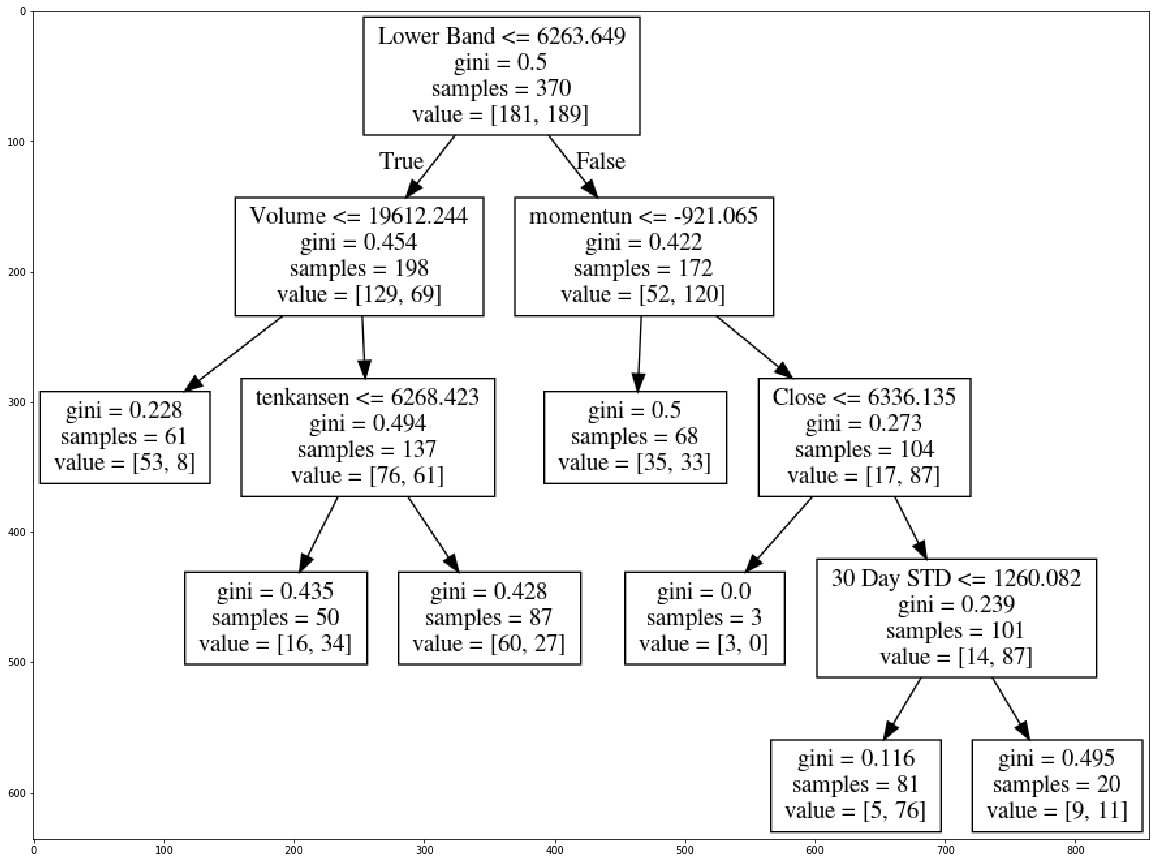

In [195]:
%%time
showTree(dct, features, 'minhaprimeiradct.png')

Para ver o desempenho do algorítmo primeiro testa-se previsões com o dataset de test e em seguida calcula-se o acerto

In [197]:
from sklearn.metrics import accuracy_score

y_pred = tree.predict(x_test)
score = accuracy_score(y_test, y_pred)*100
print('Score = {}'.format(score))

Score = 67.74193548387096


#### Problemas

Nesse teste obtemos 67% de acerto, que pode ser facilmente melhorado pois cometemos alguns erros nesse teste:

+ 1 Os dados não estavam normalizados
+ 2 Árvores de decisão tem um grande numero de impuresas e não sao a melhor opção para a aplicação
+ 3 Rodamos o algorítmo com todos os hyperparámetros e features default
+ 4 O método de teste usado não é confiável 

#### Soluções para os problemas
+ 1 Normalizar os dados na mesma escala, o scklearn tem algumas tecnicas de normalização como StandardScaler e MinMaxScaler
+ 2 Testar algorítmos mais elaborados, existem muitos a disposição como Random Forest e Gradient Boosting
+ 3 Otimizar hiperparámetros com técnicas como por exemplo GradientSearch e Bagging 
+ 4 Testar com K-fold

# Pipelines 

Para corrigir alguns erros e testar mais algorítmos com menos exforço usamos pipelines onde se encapsula os algorítmos para que possam facilmente ser treinados com maior facilidade

### Criando pipelines para teste dos modelos

#### Crio 4 pipelines e verifico a accuracia de todos com cross validation com 5 dobras utilizando diferentes combinações de scallers


+ pipeline 1 random forest com standart scaller
+ pipeline 2 random forest com minmaxacaller
+ pipeline 3 suport vector machines com minmaxscaller
+ pipeline 4 gradient boosting com minmaxscaller

In [200]:
# Scallers pra padronizar os dados no momento testarei 2 nos pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Validações e otimizações
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

#pipelines e gridsearch
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#algoritmos
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [201]:
pip_1 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', RandomForestClassifier())
])

pip_1.fit(x_train, y_train)
np.mean(cross_val_score(pip_1, x_train, y_train, cv=5))


0.7971724052819943

In [202]:
pip_2 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', BaggingClassifier(RandomForestClassifier()))
])

pip_2.fit(x_train, y_train)
np.mean(cross_val_score(pip_2, x_train, y_train, cv=5))

0.829644822905097

In [203]:
pip_3 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', svm.SVC(gamma='scale'))
])

pip_2.fit(x_train, y_train)
np.mean(cross_val_score(pip_2, x_train, y_train, cv=5))

0.8025807725533752

In [204]:
pip_4 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', GradientBoostingClassifier())
])

pip_2.fit(x_train, y_train)
np.mean(cross_val_score(pip_2, x_train, y_train, cv=5))

0.8216097741577194

### Como esperado

Os modelos com melhor resultado foram BaggingClassifier(RandomForestClassifier()) onde combinamos RandomForest com a tecnica de Bagging, e o algorítmo GradientBoostingClassifier() que já possui um ótimo historico e vence muitas competições no Kaggle.

## Automatizando testes

Pipelines são facilmente automatizadas pois podemos criar as pipelines para nosso modelo e em seguida paralelizar o processamento por meio de threads.

Abaixo cria-se 10 pipelines com combinações diferentes de algorítmos

In [205]:
# random forest - standart
pip_1 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', RandomForestClassifier())
])

# random forest + minmax + bagging
pip_2 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', BaggingClassifier(RandomForestClassifier()))
])

# random forest + minmax + bagging
pip_3 = Pipeline([
    ('min_max_scaler', StandardScaler()),
    ('clf', BaggingClassifier(RandomForestClassifier()))
])


# gradient + minmax
pip_4 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', GradientBoostingClassifier())
])

#ada boost + standart 
pip_5 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', AdaBoostClassifier())
])

# adaboost minmax + bagging
pip_6 = Pipeline([
    ('scaler',MinMaxScaler()),
    ('clf', BaggingClassifier(AdaBoostClassifier()))
])

pip_7 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', BaggingClassifier(AdaBoostClassifier()))
])

#bagging + voting
pip_8 = Pipeline([
    ('scaler',MinMaxScaler()),
    ('clf',  BaggingClassifier(KNeighborsClassifier()))
])


pip_9 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', KNeighborsClassifier())
])


pip_10 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', LogisticRegression())
])

### Pool de threads

Cria-se então uma pool de threads onde cada thread executara um pipeline e testara seu modelo, abaixo os resultados:

In [206]:
results = []

import threading
class Threads (threading.Thread):
    
    
    def __init__(self, threadID, pipeline):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.pipeline = pipeline
    
    def run(self):
        self.evalModel()
    
    def evalModel(self):
        self.pipeline.fit(x_train, y_train)
        np.mean(cross_val_score(self.pipeline, x_train, y_train, cv=5))

In [207]:
class Process():
    
    
    def __init__(self):
        self.pipelines = [pip_1, pip_2, pip_3, pip_4, pip_5, pip_6, pip_7, pip_8, pip_9, pip_10]
        self.threads = []

    def startProcess(self):
        self.createThreads()
        self.startThreads()
        self.checkThreads()
        
    def createThreads(self):
        for x in range (0, len(self.pipelines)):
            self.threads.append(Threads(x, self.pipelines[x]))
        
    def startThreads(self):
        for thread in self.threads:
            thread.start()
    
    def checkThreads(self):
        i = True
        while(i):
            if (all(thread.is_alive() == False for thread in self.threads)):
                i = False
            else:
                time.sleep(2)

In [208]:
import warnings
warnings.filterwarnings('ignore')

pc = Process()
pc.startProcess()

/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/ext

/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/ext

# ==============================================================

# Programação das rotinas do bot ignorar daqui pra baixo, tudo em construção

In [23]:
class Orders(object):
    def createOrder(self, side=SIDE_BUY, quantity=100, price='0.00001'):
        try:
            order = Client.create_test_order(
            symbol='USDTBTC',
            side=side,
            type=ORDER_TYPE_LIMIT,
            timeInForce=TIME_IN_FORCE_GTC,
            quantity=quantity,
            price=price)
        except:
            print('erro create order')
        
    def loginAPI(self):
        pass
    

class Bot(object):
    def __init__(self):
        self.botStatus = {
            'openOrder':'none',
            'lastOperation':'sell',
        }
    
    def checkStrategy(self):
        bb = Bbands()
        return bb.generateSignal()
    
    def checkSignal(self):
        signal = self.checkStrategy()
        if(signal == 'buy'):
            self.updateStatus('yes', signal)
        if (signal == 'sell'):
            self.updateStatus('no', signal)
        else:
            pass
    
    def updateStatus(self, status, operation):
        self.botStatus['openOrder'] = status
        self.botStatus['lastOperation'] = operation

In [24]:
#main thread
from IPython.display import clear_output

aq.getCandles()
aq.plotCandles()

bot = Bot()
runtime = 0
while(True):
    bot.checkSignal()
    clear_output()
    print('Runtime = %s seconds' % (runtime))
    time.sleep(2)
    runtime += 2

NameError: name 'aq' is not defined

# Criar sinal com decision (não usada so pro bot mais alem)

In [121]:
import io
from scipy import misc
from sklearn import tree # pack age tree 
from sklearn.metrics import accuracy_score # medir % acerto
from sklearn.model_selection import train_test_split # cortar dataset
from sklearn.tree import DecisionTreeClassifier, export_graphviz # arvore de decixao classificacao e graphviz para visualizar
import pydotplus

class Dct(object):
    def __init__(self, candles):
        self.candles = candles
        self.train = None
        self.test = None
        self.tree = None
        self.features = []
        self.xtrain = None
        self.ytrain = None
        self.xtest = None
        self.ytest = None
        self.fitted = None

    def split(self):
        self.train, self.test = train_test_split(self.candles, test_size=round(len(self.candles)*0.2))
    
    def castTarget(self):
        self.train['target'] = pd.to_numeric(self.train['target'], downcast='float')
        self.test['target'] = pd.to_numeric(self.test['target'], downcast='float')
        
    def createTree(self):
        self.tree = DecisionTreeClassifier(min_samples_split=100)
    
    def createFeatures(self):
        self.features = ['Open', 'High', 'Low', 'Close', 'Volume', '30 Day MA',
                   '30 Day STD', 'Upper Band', 'Lower Band', #'up_cross', 'down_cross',
                   'EMA - 15', 'aaron down', 'aaron up', 'tenkansen', 'kijunsen',
                   'momentun']
        
    def mount(self):
        self.x_train = self.train[self.features]
        self.y_train = self.train['target']
        self.x_test = self.test[self.features]
        self.y_test = self.test['target']
        
    def fitTree(self):
        self.fitted = self.tree.fit(self.x_train, self.y_train) 
        
    def showTree(self):
        file=io.StringIO()
        export_graphviz(self.tree, out_file=file, feature_names=self.features)
        pydotplus.graph_from_dot_data(file.getvalue()).write_png('dct.png')
        img = misc.imread('dct.png')
        plt.rcParams["figure.figsize"] = (20, 20)
        plt.imshow(img)
        
    def getPrediction(self):
        self.y_pred = self.fitted.predict(self.x_test)
        return accuracy_score(self.y_test, self.y_pred)*100
        
    def makePrediction(self, state):
        return self.fitted.predict(state)
        
    def getTree(self):
        self.split()
        self.castTarget()
        self.createTree()
        self.createFeatures()
        self.mount()
        self.fitTree()
        self.showTree()
        
    def createSignal(self):
        self.getTree()
        acc = self.getPrediction()
        state = self.candles.tail(1)
        state = state.drop(['target', 'date'], axis=1)
        pred = dct.makePrediction(state)
        state.head()
        if pred == 0:
            return 'buy', acc
        else: 
            return 'sell', acc

In [122]:
def runStrategy():
    #pegando os candles e calculando bbands e os cross das bandas
    bb = Bbands()
    bb.calcBands()
    bb.plotBands()
    bb.detectCross()

    #adicionando os outros indicadores
    candles = bb.candles
    candles = candles.drop(['Open_time', 'Close_time'], axis=1)
    candles['EMA - 15'] = ema(candles['Close'].tolist(), 15)
    candles['aaron down'] = aroon_down(candles['Close'].tolist(), 25)
    candles['aaron up'] = aroon_up(candles['Close'].tolist(), 25)
    candles['tenkansen'] = tenkansen(candles['Close'].tolist())
    candles['kijunsen'] = kijunsen(candles['Close'].tolist())
    candles['momentun'] = momentum(candles['Close'], 15)

    #Definindo o target
    t = Target(candles) 
    t.testTarget()
    t.plotTargets()
    createTarget(t.candles)

    #Limpando o dataframe
    dt = cleanData(t.candles)
    candles_no_NaN = dt.clean()
    candles_no_NaN.tail()

    #gerando sinal pro ultimo candle
    dct = Dct(candles_no_NaN)
    sig, acc = dct.createSignal()
    return sig, acc

NameError: name 'dct' is not defined

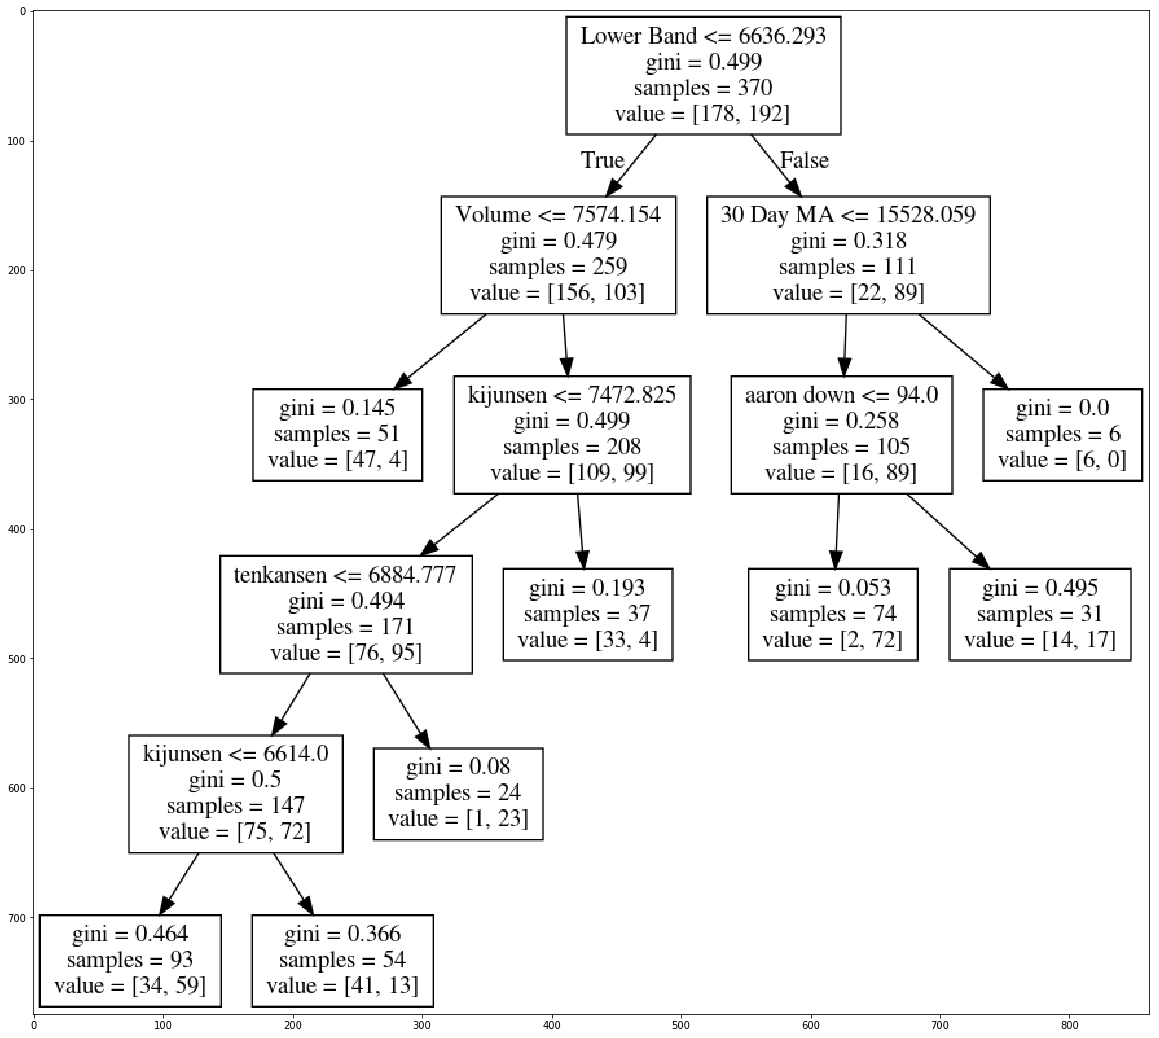

In [123]:
sig, acc = runStrategy()